###**Importing required libraries**

In [ ]:
import glob
import os
import librosa
import time
import numpy as np
import pandas as pd
from IPython.display import Audio
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt


###**List of emotions/classes**

In [ ]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fear',
  '07':'disgust',
  '08':'surprised'
}
ravdess_emotions=['neutral','calm','angry', 'happy','disgust','sad','fear','surprised']


Function to create spectogram

In [ ]:
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

###**Waveplot for sample audio file**

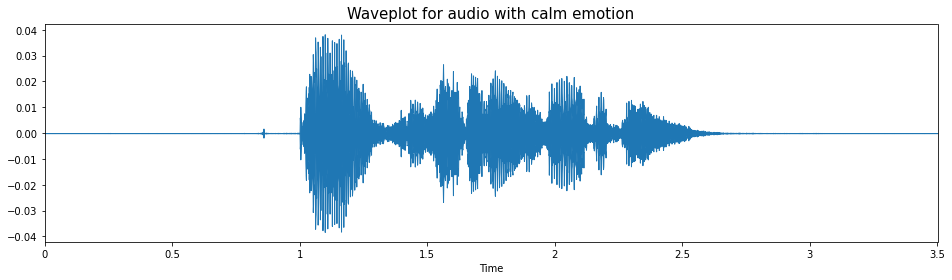

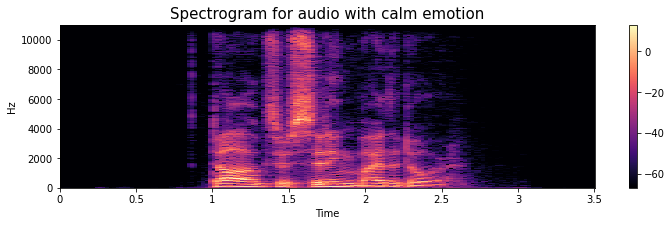

In [ ]:
#Calm Emotion
p="/content/drive/MyDrive/AudioDatabase/03-01-02-01-02-01-01.wav"
data1, sr1=librosa.load(p)
plt.figure(figsize=(16, 4))
librosa.display.waveplot(data1, sr=sr1)
plt.title('Waveplot for audio with calm emotion', size=15)
plt.show()

create_spectrogram(data1, sr1, "calm")

Audio(p)

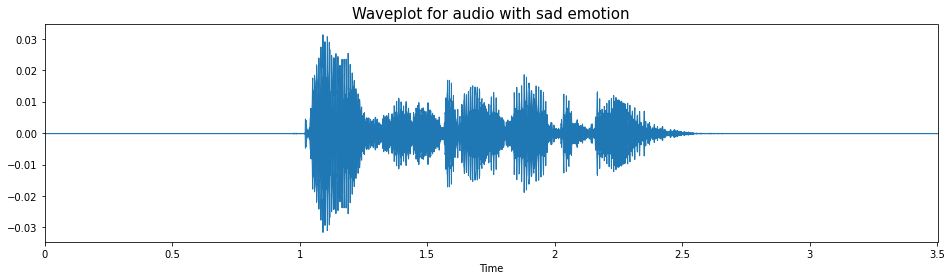

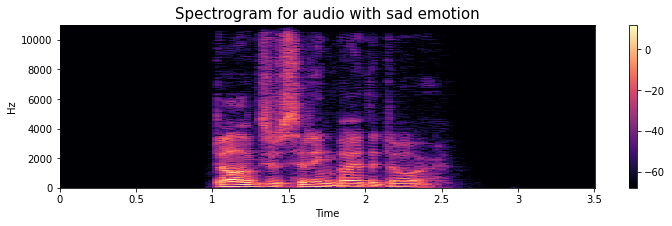

In [ ]:
#Sad Emotion
p="/content/drive/MyDrive/AudioDatabase/03-01-04-01-02-01-01.wav"
data2, sr2=librosa.load(p)
plt.figure(figsize=(16, 4))
librosa.display.waveplot(data2, sr=sr2)
plt.title('Waveplot for audio with sad emotion', size=15)
plt.show()

create_spectrogram(data2, sr2, "sad")

Audio(p)

###**Function to extract mfcc features of audio**

In [ ]:
def extract_feature(file_name, mfcc):
    result=np.array([])
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    return result

###**Loading data**

In [ ]:
def load_data(test_size=0.2): 
    x,y=[],[]
    
    # feature to extract
    mfcc = True
    paths = []
    paths.append("/content/drive/MyDrive/AudioDatabase/*.wav")    
    for path in paths:
        for file in glob.glob(path):
            file_name=os.path.basename(file)
            emotion=emotions[file_name.split("-")[2]] #to get emotion according to filename. dictionary emotions is defined above.
            if emotion not in ravdess_emotions: #options observed_emotions - RAVDESS and TESS, ravdess_emotions for RAVDESS only
                continue
            feature=extract_feature(file, mfcc)
            x.append(feature)
            y.append(emotion)
    return {"X":x,"y":y}

In [ ]:
Trial_dict = load_data()
print(Trial_dict)

###**Saving data (python dictionary) as pickle file**

In [ ]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('/content/drive/MyDrive/ML Proj/dict_data.p', 'wb') as fp:
    pickle.dump(Trial_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/drive/MyDrive/ML Proj/dict_data.p', 'rb') as fp:
    ch = pickle.load(fp)

In [ ]:
print(ch['y'])

In [ ]:
X = pd.DataFrame(Trial_dict["X"])
y = pd.DataFrame(Trial_dict["y"])

In [ ]:
X.shape, y.shape

((2454, 40), (2454, 1))

In [ ]:
y=y.rename(columns= {0: 'emotion'})

In [ ]:
df = pd.concat([X, y], axis =1)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,emotion
0,-736.652527,76.044174,7.125304,28.491140,3.620725,8.973257,0.902409,-0.131022,-2.231665,0.816929,-2.454634,0.184902,-0.697577,2.703344,-0.878772,1.241181,-1.337911,3.611596,0.457819,4.620700,-1.657097,3.071855,-1.888906,2.453950,-1.609333,-0.255605,-0.286482,1.444610,1.462739,3.292415,-0.998575,2.341936,3.024025,6.731739,9.278235,10.521128,7.394755,3.940343,3.280124,2.208377,sad
1,-660.566223,63.146446,-3.664754,23.336290,5.285973,2.867422,-2.358670,-3.803257,-2.460194,1.228756,-4.155738,0.009006,-4.205925,3.867896,-2.681122,-1.906687,-4.060986,3.024120,-3.632118,2.701772,-0.597193,0.467919,-0.365178,2.152280,-2.112612,-0.025854,-0.209887,3.545753,4.017648,6.958835,4.370861,4.645700,3.115983,3.780183,5.537939,5.026135,4.619511,2.284226,2.115680,3.976479,happy
2,-724.002869,71.444817,9.892778,19.885513,5.390996,6.566319,-11.265408,2.427420,-1.621379,4.408065,-3.700138,4.519842,-0.326592,2.208724,0.908890,3.649582,-5.414191,1.166484,-1.310520,1.023967,-5.919950,-2.803682,-2.915926,-3.642746,-1.458520,1.274154,-2.772168,0.208972,-2.414719,-2.067325,-3.538138,0.046339,-1.701495,0.571199,-2.888359,-2.311700,-4.285143,-2.035397,-0.485385,1.218064,disgust
3,-539.284851,52.943172,-0.900867,22.278574,-4.861354,-10.531145,-5.549105,4.013939,-12.937896,-0.609211,-4.204734,-0.865897,-4.532799,1.664522,-6.929902,4.124241,-8.163391,0.812906,-2.842448,-2.494404,-6.745531,-0.477727,-5.758527,-2.629900,-1.378546,-0.166911,-0.994567,2.787396,-0.965891,-0.300911,-1.925583,1.460056,2.639029,3.107945,3.953407,2.068609,0.891135,3.118755,3.145329,3.114293,disgust
4,-626.947144,69.112015,5.087786,19.956352,4.035838,-4.200925,-6.704655,-4.466947,-5.047968,-0.198660,-9.243311,3.372931,-3.048552,-2.449069,-1.809802,0.930675,-6.610584,4.958179,-4.829471,1.362362,-6.469028,-0.947245,-3.706686,-4.577216,-2.910887,0.230719,-2.913803,-0.133100,-2.183258,-1.336212,-3.825766,0.258472,-1.787566,-0.443790,-0.181241,-1.909223,-3.523956,-1.737269,-1.435431,0.015934,surprised


###**Saving dataframe as csv file**

In [ ]:
#reindexing to shuffle the data at random
df = df.reindex(np.random.permutation(df.index))

# Storing shuffled ravdess data to avoid loading again
df.to_csv("/content/drive/MyDrive/ML Proj/RAVDESS_Observed.csv")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ML Proj/RAVDESS_Observed.csv")


In [ ]:
df.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', 'emotion'],
      dtype='object')

In [ ]:
#dropping the column Unnamed: 0 to removed shuffled index
df = df.drop('Unnamed: 0',axis=1)

In [ ]:
#separating features and target outputs
X = df.drop('emotion', axis = 1).values
y = df['emotion'].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
from sklearn.svm import SVC

###**SVM for multi class classification, linear kernel and one vs one decision strategy**

In [ ]:
svm_mc = SVC(kernel='linear',decision_function_shape='ovo')
svm_mc.fit(X_train, y_train)
y_pred = svm_mc.predict(X_test)


In [ ]:
y_pr_tr = svm_mc.predict(X_train)
tr_acc = float(accuracy_score(y_train,y_pr_tr))*100
print("----training accuracy score %s ----" % tr_acc)

----training accuracy score 68.21192052980133 ----


              precision    recall  f1-score   support

       angry       0.68      0.81      0.74        77
        calm       0.57      0.72      0.64        75
     disgust       0.55      0.34      0.42        50
        fear       0.61      0.59      0.60        73
       happy       0.66      0.58      0.62        76
     neutral       0.57      0.49      0.52        35
         sad       0.49      0.59      0.53        58
   surprised       0.61      0.47      0.53        47

    accuracy                           0.60       491
   macro avg       0.59      0.57      0.57       491
weighted avg       0.60      0.60      0.59       491

----accuracy score 59.67413441955194 ----


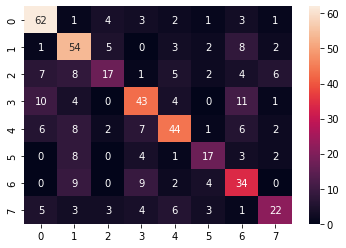

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt

print(classification_report(y_test,y_pred))

acc = float(accuracy_score(y_test,y_pred))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

###**SVM for multi class classification, linear kernel and one vs rest decision strategy**

In [ ]:
svm_dag = SVC(kernel='linear',decision_function_shape='ovr')
svm_dag.fit(X_train, y_train)
y_hat = svm_dag.predict(X_test)


              precision    recall  f1-score   support

       angry       0.74      0.80      0.77        70
        calm       0.59      0.74      0.66        81
     disgust       0.55      0.52      0.54        50
        fear       0.60      0.65      0.62        71
       happy       0.60      0.55      0.58        74
     neutral       0.48      0.37      0.42        38
         sad       0.49      0.49      0.49        72
   surprised       0.45      0.29      0.35        35

    accuracy                           0.59       491
   macro avg       0.56      0.55      0.55       491
weighted avg       0.58      0.59      0.58       491

----accuracy score 58.65580448065173 ----


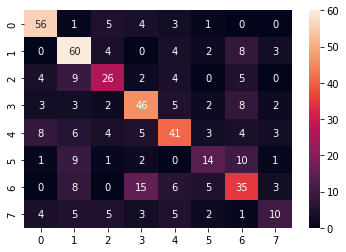

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt

print(classification_report(y_test,y_hat))

acc = float(accuracy_score(y_test,y_hat))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(y_test,y_hat)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

###**SVM for multi class classification, polynomial kernel and one vs rest decision strategy**

In [ ]:
svm_poly = SVC(kernel = 'poly', decision_function_shape='ovr')
starting_time = time.time()
svm_poly.fit(X_train, y_train)
print("Trained model in %s ms " % str(time.time() - starting_time))
y_pred = svm_poly.predict(X_test)

Trained model in 0.32152271270751953 ms 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       angry       0.39      0.68      0.49        77
        calm       0.38      0.52      0.44        75
     disgust       0.00      0.00      0.00        50
        fear       0.14      0.25      0.17        73
       happy       0.00      0.00      0.00        76
     neutral       0.00      0.00      0.00        35
         sad       0.19      0.40      0.26        58
   surprised       0.00      0.00      0.00        47

    accuracy                           0.27       491
   macro avg       0.14      0.23      0.17       491
weighted avg       0.16      0.27      0.20       491

----accuracy score 26.883910386965375 ----


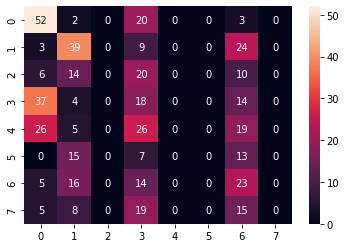

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt

print(classification_report(y_test,y_pred))

acc = float(accuracy_score(y_test,y_pred))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()